## preparing tokenized data

In [218]:
# import libraries
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
pd.set_option('display.max_colwidth', 80)

In [2]:
# read the json file into a dataframe
df = pd.read_json('reviews.json', lines=True)
data = df[["reviewText", "overall", "summary"]]

In [3]:
data.head()

,reviewText,overall,summary
0,"This came in on time and I am veru happy with it, I haved used it already an...",5,Woks very good
1,"I had a factory Glock tool that I was using for my Glock 26, 27, and 17. I'...",5,Works as well as the factory tool
2,"If you don't have a 3/32 punch or would like to have one in your Glock bag, ...",4,"It's a punch, that's all."
3,This works no better than any 3/32 punch you would find at the hardware stor...,4,It's a punch with a Glock logo.
4,I purchased this thinking maybe I need a special tool to easily pop off my b...,4,"Ok,tool does what a regular punch does."


In [4]:
# the preprocess_documents function in gensim automatically stem
# which is not desired
# thus this customized gensim_strip function

#from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_multiple_whitespaces

def gensim_strip(input_data):
    input_data = input_data.lower()
    input_data = strip_tags(input_data)
    input_data = strip_short(input_data, minsize = 3)
    input_data = strip_punctuation(input_data)
    input_data = strip_numeric(input_data)
    input_data = strip_non_alphanum(input_data)
    input_data = strip_multiple_whitespaces(input_data)
    return input_data

In [5]:
import spacy

# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load("en_core_web_sm")

In [6]:
# preprocess text using strip and lemmatization
def tokenvec(line):
    line = gensim_strip(line)
    doc = nlp(line)
    doc = [token.lemma_ for token in doc]
    return [token for token in doc if len(token) >= 3]

In [7]:
reviewText_token = []
summary_token = []
for index, row in data.iterrows():
    reviewText_token.append(tokenvec(row['reviewText']))
    summary_token.append(tokenvec(row['summary']))
data['tokenized review'] = reviewText_token
data['tokenized summary'] = summary_token
data.head()

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_63869/4063547692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokenized review'] = reviewText_token
/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_63869/4063547692.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokenized summary'] = summary_token


,reviewText,overall,summary,tokenized review,tokenized summary
0,"This came in on time and I am veru happy with it, I haved used it already an...",5,Woks very good,"[this, come, time, and, veru, happy, with, have, use, already, and, make, ta...","[wok, very, good]"
1,"I had a factory Glock tool that I was using for my Glock 26, 27, and 17. I'...",5,Works as well as the factory tool,"[have, factory, glock, tool, that, use, for, glock, and, since, lose, and, h...","[work, well, the, factory, tool]"
2,"If you don't have a 3/32 punch or would like to have one in your Glock bag, ...",4,"It's a punch, that's all.","[you, don, have, punch, would, like, have, one, your, glock, bag, this, okay...","[punch, that, all]"
3,This works no better than any 3/32 punch you would find at the hardware stor...,4,It's a punch with a Glock logo.,"[this, work, well, than, any, punch, you, would, find, the, hardware, store,...","[punch, with, glock, logo]"
4,I purchased this thinking maybe I need a special tool to easily pop off my b...,4,"Ok,tool does what a regular punch does.","[purchase, this, thinking, maybe, need, special, tool, easily, pop, off, bas...","[tool, what, regular, punch]"


In [8]:
df = data[['overall', 'tokenized review', 'tokenized summary']]
df.head()

,overall,tokenized review,tokenized summary
0,5,"[this, come, time, and, veru, happy, with, have, use, already, and, make, ta...","[wok, very, good]"
1,5,"[have, factory, glock, tool, that, use, for, glock, and, since, lose, and, h...","[work, well, the, factory, tool]"
2,4,"[you, don, have, punch, would, like, have, one, your, glock, bag, this, okay...","[punch, that, all]"
3,4,"[this, work, well, than, any, punch, you, would, find, the, hardware, store,...","[punch, with, glock, logo]"
4,4,"[purchase, this, thinking, maybe, need, special, tool, easily, pop, off, bas...","[tool, what, regular, punch]"


In [11]:
# the lemmatizing takes time
# so for future convenience,
# save the lammatized and stripped reviews and summaries into a csv file
import os

if not os.path.isfile('./data cleaned.csv'):
    reviewtext_str = []
    summary_str = []
    rating = df['overall']
    df_copy = df
    for index, row in df.iterrows():
        review = " ".join([token for token in row['tokenized review']])
        reviewtext_str.append(review)
        summary = " ".join([token for token in row['tokenized summary']])
        summary_str.append(summary)
    df_copy['review str'] = reviewtext_str
    df_copy['summary str'] = summary_str
    df_copy[['overall', 'review str', 'summary str']].to_csv('data cleaned.csv', index = False)

## word2vec modeling

In [12]:
# retrieve data if not exist in the current memory
try:
    print(df.head())
except:
    df = pd.read_csv('data cleaned.csv')
    r, s = [], []
    for index, row in df.iterrows():
        r.append(row['review str'].split())
        s.append(row['summary str'].split())
    df.rename({'review str': 'tokenized review', 'summary str': 'tokenized summary'}, axis='columns')
    df['tokenized review'] = r
    df['tokenized summary'] = s
    df.head()

   overall  \
0        5   
1        5   
2        4   
3        4   
4        4   

                                                                  tokenized review  \
0  [this, come, time, and, veru, happy, with, have, use, already, and, make, ta...   
1  [have, factory, glock, tool, that, use, for, glock, and, since, lose, and, h...   
2  [you, don, have, punch, would, like, have, one, your, glock, bag, this, okay...   
3  [this, work, well, than, any, punch, you, would, find, the, hardware, store,...   
4  [purchase, this, thinking, maybe, need, special, tool, easily, pop, off, bas...   

                  tokenized summary  \
0                 [wok, very, good]   
1  [work, well, the, factory, tool]   
2                [punch, that, all]   
3        [punch, with, glock, logo]   
4      [tool, what, regular, punch]   

                                                                        review str  \
0  this come time and veru happy with have use already and make take out the 

In [250]:
# Split data into train and test sets
SEED = 42
X_train_review, X_test_review, y_train, y_test = train_test_split(df['tokenized review'].tolist(), 
                                                                  df['overall'].tolist(),
                                                                  test_size=0.2, random_state = SEED)

#X_train_summary, X_test_summary, y_train, y_test = train_test_split(df['tokenized summary'].tolist(), 
#                                                                    df['overall'].tolist(),
#                                                                    test_size=0.2, random_state = SEED)

In [16]:
# Train the word2vec model based on reviewText
w2v_model = gensim.models.Word2Vec(X_train_review,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [17]:
w2v_model.wv.index_to_key[:10]

['the', 'and', 'for', 'this', 'have', 'you', 'that', 'with', 'but', 'not']

In [18]:
# Find the most similar words to "great" based on word vectors from our trained model
w2v_model.wv.most_similar('great')

[('fantastic', 0.840336799621582),
 ('excellent', 0.7991260290145874),
 ('awesome', 0.7884966135025024),
 ('good', 0.7774312496185303),
 ('wonderful', 0.7198064923286438),
 ('nice', 0.6559269428253174),
 ('perfect', 0.6415774822235107),
 ('terrific', 0.6379780769348145),
 ('wonderfully', 0.6291117072105408),
 ('outstanding', 0.6234756708145142)]

In [20]:
words = set(w2v_model.wv.index_to_key)
X_train_vect_review = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train_review])
X_test_vect_review = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test_review])
X_train_vect_summary = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train_summary])
X_test_vect_summary = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test_summary])

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_63869/1608238791.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect_review = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_63869/1608238791.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect_review = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_63869/1608238791.py:6: VisibleDeprecationWarning: Creating an ndarray 

In [21]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg_review = []
for v in X_train_vect_review:
    if v.size:
        X_train_vect_avg_review.append(v.mean(axis=0))
    else:
        X_train_vect_avg_review.append(np.zeros(100, dtype=float))
        
X_test_vect_avg_review = []
for v in X_test_vect_review:
    if v.size:
        X_test_vect_avg_review.append(v.mean(axis=0))
    else:
        X_test_vect_avg_review.append(np.zeros(100, dtype=float))
        
X_train_vect_avg_summary = []
for v in X_train_vect_summary:
    if v.size:
        X_train_vect_avg_summary.append(v.mean(axis=0))
    else:
        X_train_vect_avg_summary.append(np.zeros(100, dtype=float))
        
X_test_vect_avg_summary = []
for v in X_test_vect_summary:
    if v.size:
        X_test_vect_avg_summary.append(v.mean(axis=0))
    else:
        X_test_vect_avg_summary.append(np.zeros(100, dtype=float))

In [22]:
for i in range(5):
    print(len(X_train_vect_review[i]), len(X_train_vect_avg_review[i]))

28 100
144 100
68 100
20 100
30 100


## random forest to see if there is a difference between review text and summary

In [26]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg_review, y_train)

In [27]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg_review)

In [28]:
y_pred[:20]

array([5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6498953904299116

In [30]:
# Use the trained model to make predictions on the test data
y_pred_s = rf_model.predict(X_test_vect_avg_summary)

In [31]:
accuracy_score(y_test, y_pred_s)

0.5809543092393872

Therefore we will proceeed whith the vecs from the review text.

## classification using neural net

In [81]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split

In [251]:
# split the validation set from the test data
X_train, X_val, y_train, y_val = train_test_split(X_train_vect_avg_review, y_train, 
                                                  test_size=0.15, 
                                                  shuffle=True,
                                                 random_state = SEED)

In [252]:
y_train = [x - 1 for x in y_train]
y_val = [x - 1 for x in y_val]
y_test = [x - 1 for x in y_test]

In [253]:
# prepare data for keras
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test = tf.data.Dataset.from_tensor_slices((X_test_vect_avg_review, y_test))

2024-02-28 10:46:11.981840: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [254]:
train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [255]:
train = train.batch(32)
val = val.batch(32)

In [256]:
AUTOTUNE = tf.data.AUTOTUNE
#BATCH_SIZE = 32
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [257]:
#define our model

model = Sequential()
model.add(layers.Dense(64, input_shape=(100,), activation='softmax'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='softmax'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='sigmoid'))

#model.build((32, 100))
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 64)                6464      
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 dropout_53 (Dropout)        (None, 32)                0         
                                                                 
 dense_52 (Dense)            (None, 5)                 165       
                                                                 
Total params: 8709 (34.02 KB)
Trainable params: 8709 (34.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [258]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',
              metrics=['accuracy'])

In [260]:
#start training
epochs = 20

checkpoint_filepath = './checkpoint.model2.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1)

history = model.fit(
    train,
    validation_data=val,
    epochs=epochs,
    batch_size=32,
    callbacks=[model_checkpoint_callback, earlystop_callback])

Epoch 1/20
6298/6298 [==============================] - 4s 620us/step - loss: 0.8926 - accuracy: 0.6493 - val_loss: 0.8706 - val_accuracy: 0.6563
Epoch 2/20
6298/6298 [==============================] - 4s 614us/step - loss: 0.8879 - accuracy: 0.6516 - val_loss: 0.8668 - val_accuracy: 0.6582
Epoch 3/20
6298/6298 [==============================] - 4s 623us/step - loss: 0.8854 - accuracy: 0.6518 - val_loss: 0.8643 - val_accuracy: 0.6589
Epoch 4/20
6298/6298 [==============================] - 4s 621us/step - loss: 0.8833 - accuracy: 0.6523 - val_loss: 0.8627 - val_accuracy: 0.6599
Epoch 5/20
6298/6298 [==============================] - 4s 612us/step - loss: 0.8806 - accuracy: 0.6528 - val_loss: 0.8600 - val_accuracy: 0.6606
Epoch 6/20
6298/6298 [==============================] - 4s 614us/step - loss: 0.8777 - accuracy: 0.6542 - val_loss: 0.8583 - val_accuracy: 0.6615
Epoch 7/20
6298/6298 [==============================] - 4s 619us/step - loss: 0.8748 - accuracy: 0.6549 - val_loss: 0.8561 -

## evaluate model perfomance

In [263]:
test = test.batch(32)

In [264]:
loss, accuracy = model.evaluate(test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1853/1853 [==============================] - 1s 403us/step - loss: 0.8542 - accuracy: 0.6632
Loss:  0.8541759848594666
Accuracy:  0.6632415652275085


In [265]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

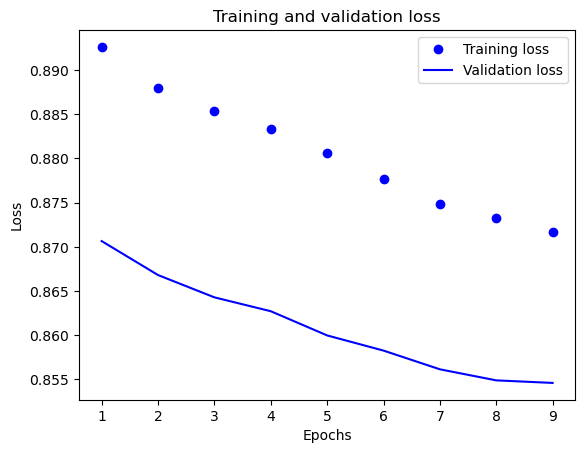

In [266]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

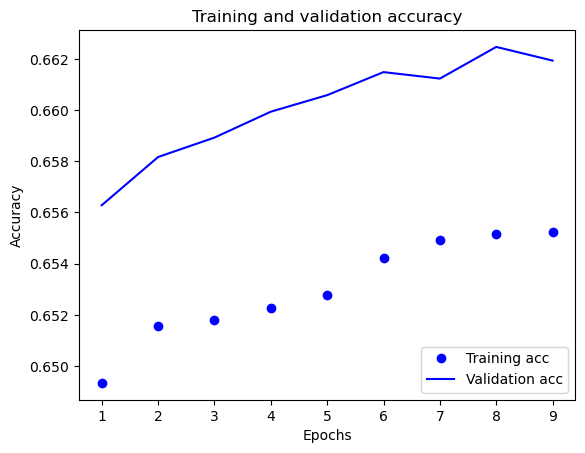

In [267]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [269]:
export_model = tf.keras.Sequential([
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test)
print(accuracy)

1853/1853 [==============================] - 1s 381us/step - loss: 1.3050 - accuracy: 0.6632
0.6632415652275085
